In [78]:
# ==============================================================================
# Copyright 2021 Google LLC. This software is provided as-is, without warranty
# or representation for any use or purpose. Your use of it is subject to your
# agreement with Google.
# ==============================================================================
#
# Author: Chanchal Chatterjee
# Email: cchatterjee@google.com
#

In [79]:
# To these first:
# 1. Create a VM with TF 2.1
# 2. Create the following buckets in your project:
#    Root Bucket:               BUCKET_NAME    = 'tuti_asset'  'gs://$BUCKET_NAME'
#    Model Results Directory:   FOLDER_RESULTS = 'tf_models'   'gs://$BUCKET_NAME/$FOLDER_RESULTS'
#    Data directory:            FOLDER_DATA    = 'datasets'    'gs://$BUCKET_NAME/$FOLDER_DATA'
#    The data:                  INPUT_FILE_NAME = 'mortgage_structured.csv'
# 3. In your VM create directory called ./model_dir


In [80]:
# Uninstall old packages
#!pip3 uninstall -r requirements-uninstall.txt -y


In [81]:
# Install packages
# https://cloud.google.com/ai-platform/training/docs/runtime-version-list
#!pip3 install -r requirements-rt2.1.txt --user --ignore-installed

# If VM created with TF2.1 Enterprise (no GPUs), all you need to install is cloudml-hypertune
!pip3 install cloudml-hypertune --user --ignore-installed


  Using cached cloudml_hypertune-0.1.0.dev6-py2.py3-none-any.whl


In [82]:
# Import packages
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed

import numpy as np
from google.cloud import storage
import tensorflow as tf
#import matplotlib.pyplot as plt
#from tensorflow.keras import models

print("TF Version= ", tf.__version__)
print("Keras Version= ", tf.keras.__version__)


TF Version=  2.1.3
Keras Version=  2.3.0-tf


In [83]:
# Utility functions

#------
def find_best_model_dir(model_dir, offset=1, maxFlag=1):
    # Get a list of model directories
    all_models = ! gsutil ls $model_dir
    print("")
    print("All Models = ")
    print(*all_models, sep='\n')

    # Check if model dirs exist
    if (("CommandException" in all_models[0]) or (len(all_models) <= 1)):
        print("Create the models first.")
        return ""

    # Find the best model from checkpoints
    import re
    best_acc = -np.Inf
    if (maxFlag != 1):
        best_acc = np.Inf
    best_model_dir = ""
    tup_list = []
    for i in range(1,len(all_models)):
        all_floats = re.findall(r"[-+]?\d*\.\d+|\d+", all_models[i]) #Find the floats in the string
        cur_acc = -float(all_floats[-offset]) #which item is the model optimization metric
        tup_list.append([all_models[i],cur_acc])
        if (maxFlag*(cur_acc > best_acc) or (1-maxFlag)*(cur_acc < best_acc)):
            best_acc = cur_acc
            best_model_dir = all_models[i]
    if maxFlag:
        tup_list.sort(key=lambda tup: tup[1], reverse=False)
    else:
        tup_list.sort(key=lambda tup: tup[1], reverse=True)
    for i in range(len(tup_list)):
        print(tup_list[i][0])
    print("Best Accuracy  from Checkpoints = ", best_acc)
    print("Best Model Dir from Checkpoints = ", best_model_dir)
    
    return best_model_dir


In [84]:
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors
import json

#------
# Python module to get the best hypertuned model parameters
def pyth_get_hypertuned_parameters(project_name, job_name, maxFlag):
    # Define the credentials for the service account
    #credentials = service_account.Credentials.from_service_account_file(<PATH TO CREDENTIALS JSON>)
    credentials = GoogleCredentials.get_application_default()

    # Define the project id and the job id and format it for the api request
    project_id = 'projects/{}'.format(project_name)
    job_id = '{}/jobs/{}'.format(project_id, job_name)

    # Build the service
    cloudml = discovery.build('ml', 'v1', cache_discovery=False, credentials=credentials)

    # Execute the request and pass in the job id
    request = cloudml.projects().jobs().get(name=job_id)

    try:
        response = request.execute()
        # Handle a successful request
    except errors.HttpError as err:
        tf.compat.v1.logging.error('There was an error getting the hyperparameters. Check the details:')
        tf.compat.v1.logging.error(err._get_reason())

    # Get just the best hp values
    if maxFlag:
        best_model = response['trainingOutput']['trials'][0]
    else:
        best_model = response['trainingOutput']['trials'][-1]
    #print('Best Hyperparameters:')
    #print(json.dumps(best_model, indent=4))

    nTrials = len(response['trainingOutput']['trials'])
    for i in range(0,nTrials):
        state = response['trainingOutput']['trials'][i]['state']
        trialId = response['trainingOutput']['trials'][i]['trialId']
        objV = -1
        if (state == 'SUCCEEDED'):
            objV = response['trainingOutput']['trials'][i]['finalMetric']['objectiveValue']
        print('objective=', objV, ' trialId=', trialId, state)
        d = response['trainingOutput']['trials'][i]['hyperparameters']
        for key, value in d.items():
            print('    ', key, value)
    return best_model


# Setup

In [ ]:
# Get the project id
proj_id = !gcloud config list project --format "value(core.project)"
proj_id[0]


In [85]:
USER = 'cchatterj'
PROJECT_ID = proj_id[0]
BUCKET_NAME = 'tuti_asset' #Use a unique name
FOLDER_RESULTS = 'tf_models'
FOLDER_DATA = 'datasets'
REGION = 'us-central1'
ZONE1 = 'us-central1-a'
RUNTIME_VERSION = 2.1
JOB_DIR   = 'gs://' + BUCKET_NAME + '/' + FOLDER_RESULTS + '/jobdir'
MODEL_DIR = 'gs://' + BUCKET_NAME + '/' + FOLDER_RESULTS + '/models'
INPUT_FILE_NAME = 'mortgage_structured.csv'


In [86]:
!gcloud config set project $PROJECT_ID
!gcloud config set compute/zone $ZONE1
!gcloud config set compute/region $REGION
!gcloud config list
#!gcloud config config-helper --format "value(configuration.properties.core.project)"


Updated property [core/project].
Updated property [compute/zone].
Updated property [compute/region].
[compute]
region = us-central1
zone = us-central1-a
[core]
account = 122476304848-compute@developer.gserviceaccount.com
disable_usage_reporting = True
project = img-seg-3d

Your active configuration is: [default]


In [87]:
# Clean old job logs, job packages and models
!gsutil -m -q rm $JOB_DIR/packages/**
!gsutil -m -q rm $MODEL_DIR/model**


# ML Model

In [88]:
# Create the tf_trainer directory and load the trainer files in it
!mkdir -p trainer


In [89]:
%%writefile ./trainer/inputs.py

# Create the train and label lists
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

#------
def load_data(input_file):
    # Read the data
    print(input_file)
    #try:
    table_data = pd.read_csv(input_file)
    #except:
    #    print("Oops! That is invalid filename. Try again...")
    #    return

    print(table_data.shape)

    # ---------------------------------------
    # Pre-processing
    # ---------------------------------------

    # Drop useless columns
    table_data.drop(['LOAN_SEQUENCE_NUMBER'], axis=1, inplace=True)

    # Inputs to an XGBoost model must be numeric. One hot encoding was 
    # previously found to yield better results 
    # than label encoding for the particular
    strcols = [col for col in table_data.columns if table_data[col].dtype == 'object']
    table_data = pd.get_dummies(table_data, columns=strcols)

    # Train Test Split and write out the train-test files

    # Split with a small test size so as to allow our model to train on more data
    X_train, X_test, y_train, y_test = \
        train_test_split(table_data.drop('TARGET', axis=1), 
                         table_data['TARGET'],
                         stratify=table_data['TARGET'], 
                         shuffle=True, test_size=0.2
                        )

    # Remove Null and NAN
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    
    # Check the shape
    print("X_train shape = ", X_train.shape)
    print("X_test  shape = ", X_test.shape)
    
    y_train_cat = tf.keras.utils.to_categorical(y_train)
    y_test_cat = tf.keras.utils.to_categorical(y_test)
    print("y_train shape = ", y_train_cat.shape)
    print("y_test  shape = ", y_test_cat.shape)

    # count number of classes
    #values, counts = np.unique(y_train, return_counts=True)
    #NUM_CLASSES = len(values)
    #print("Number of classes ", NUM_CLASSES)

    #train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    #train_dataset = train_dataset.shuffle(100).batch(batch_size)
    #test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    #test_dataset = test_dataset.shuffle(100).batch(batch_size)
    
    return [X_train, X_test, y_train_cat, y_test_cat]


Overwriting ./trainer/inputs.py


In [90]:
%%writefile ./trainer/model.py

import tensorflow as tf
import numpy as np

def tf_model(input_dim, output_dim, model_depth: int = 1, dropout_rate: float = 0.02):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout

    decr = int((input_dim-output_dim-16)/model_depth) ^ 1

    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation=tf.nn.relu))
    for i in range(1,model_depth):
        model.add(Dense(input_dim-i*decr, activation=tf.nn.relu, kernel_regularizer='l2'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_dim, activation=tf.nn.softmax))
    print(model.summary())

    return model


def custom_loss(y_true, y_pred):
    custom_loss = mean(square(y_true - y_pred), axis=-1)
    return custom_loss

def custom_metric(y_true, y_pred):
    custom_metric = mean(square(y_true - y_pred), axis=-1)
    return custom_metric


Overwriting ./trainer/model.py


## Package for distributed training

In [91]:
%%writefile ./setup.py

# python3

# ==============================================================================
# Copyright 2020 Google LLC. This software is provided as-is, without warranty
# or representation for any use or purpose. Your use of it is subject to your
# agreement with Google.
# ==============================================================================

# https://cloud.google.com/ai-platform/training/docs/runtime-version-list

from setuptools import find_packages
from setuptools import setup

#Runtime 2.1
REQUIRED_PACKAGES = ['tensorflow==2.1.0',
                     'pandas==0.25.3',
                     'scikit-learn==0.22',
                     'google-cloud-storage==1.23.0',
                     'gcsfs==0.6.1',
                     'cloudml-hypertune',
                    ]
setup(
    name='trainer',
    version='0.1',
    install_requires=REQUIRED_PACKAGES,
    packages=find_packages(),
    include_package_data=True,
    description='Trainer package for Tensorflow Task'
)


Overwriting ./setup.py


## Training functions

In [92]:
%%writefile ./trainer/__init__.py
# python3

# ==============================================================================
# Copyright 2020 Google LLC. This software is provided as-is, without warranty
# or representation for any use or purpose. Your use of it is subject to your
# agreement with Google.
# ==============================================================================


Overwriting ./trainer/__init__.py


In [153]:
%%writefile ./trainer/train.py

# python3
# ==============================================================================
# Copyright 2020 Google LLC. This software is provided as-is, without warranty
# or representation for any use or purpose. Your use of it is subject to your
# agreement with Google.
# ==============================================================================

import os
import json
import tensorflow as tf
import numpy as np
import datetime as datetime
from pytz import timezone
import hypertune
import argparse
from trainer import model
from trainer import inputs


import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed


def parse_arguments():
    """Argument parser.
    Returns:
      Dictionary of arguments.
    """

    parser = argparse.ArgumentParser()
    parser.add_argument('--model_depth', default=3, type=int, 
                        help='Hyperparameter: depth of model')
    parser.add_argument('--dropout_rate', default=0.02, type=float, 
                        help='Hyperparameter: Drop out rate')
    parser.add_argument('--learning_rate', default=0.0001, type=float, 
                        help='Hyperparameter: initial learning rate')
    parser.add_argument('--batch_size', default=4, type=int, 
                        help='batch size of the deep network')
    parser.add_argument('--epochs', default=1, type=int, 
                        help='number of epochs.')
    parser.add_argument('--model_dir', default="",
                        help='Directory to store model checkpoints and logs.')
    parser.add_argument('--input_file', default="",
                        help='Directory to store model checkpoints and logs.')
    parser.add_argument('--verbosity', choices=['DEBUG','ERROR','FATAL','INFO','WARN'],
                        default='FATAL')
    args, _ = parser.parse_known_args()
    return args


def get_callbacks(args, early_stop_patience: int = 3):
    """Creates Keras callbacks for model training."""

    # Get trialId
    trialId = json.loads(os.environ.get("TF_CONFIG", "{}")).get("task", {}).get("trial", "")
    if trialId == '':
        trialId = '0'
    print("trialId=", trialId)

    curTime = datetime.datetime.now(timezone('US/Pacific')).strftime('%H%M%S')
    
    # Modify model_dir paths to include trialId
    model_dir = args.model_dir + "/checkpoints/cp-"+curTime+"-"+trialId+"-{val_accuracy:.4f}"
    log_dir   = args.model_dir + "/log_dir"

    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    checkpoint_cb  = tf.keras.callbacks.ModelCheckpoint(model_dir, monitor='val_accuracy', mode='max', 
                                                        verbose=0, save_best_only=True,
                                                        save_weights_only=False)
    earlystop_cb   = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

    return [checkpoint_cb, tensorboard_cb, earlystop_cb]


if __name__ == "__main__":

    # ---------------------------------------
    # Parse Arguments
    # ---------------------------------------
    args = parse_arguments()
    #args.model_dir = MODEL_DIR + datetime.datetime.now(timezone('US/Pacific')).strftime('/model_%m%d%Y_%H%M')
    #args.input_file = 'gs://' + BUCKET_NAME + '/' + FOLDER_DATA + '/' + INPUT_FILE_NAME
    print(args)

    # ---------------------------------------
    # Input Data & Preprocessing
    # ---------------------------------------
    print("Input and pre-process data ...")
    # Extract train_seismic, train_label
    train_test_data = inputs.load_data(args.input_file)
    X_train = train_test_data[0]
    X_test  = train_test_data[1]
    y_train = train_test_data[2]
    y_test  = train_test_data[3]

    # ---------------------------------------
    # Train model
    # ---------------------------------------
    print("Creating model ...")
    print("x_train")
    print(X_train.shape[1])
    print("y_train")
    print(y_train.shape[1])

    tf_model = model.tf_model(X_train.shape[1], y_train.shape[1], 
                              model_depth=args.model_depth,
                              dropout_rate=args.dropout_rate)
    
    tf_model.compile(optimizer=tf.keras.optimizers.Adam(lr=args.learning_rate),
                     loss='mean_squared_error',
                     metrics=['accuracy'])
    
    print("Fitting model ...")
    callbacks = get_callbacks(args, 3)
    histy = tf_model.fit(np.array(X_train), y_train, 
                         epochs=args.epochs,
                         batch_size=args.batch_size,
                         validation_data=[np.array(X_test),y_test],
                         callbacks=callbacks)

    # TBD save history for visualization

    final_epoch_accuracy = histy.history['accuracy'][-1]
    final_epoch_count = len(histy.history['accuracy'])

    print('final_epoch_accuracy = %.6f' % final_epoch_accuracy)
    print('final_epoch_count = %2d' % final_epoch_count)


Overwriting ./trainer/train.py


In [154]:
%%time
# Run the training manually
# Training parameters
from datetime import datetime
from pytz import timezone

MODEL_DEPTH = 2
DROPOUT_RATE = 0.01
LEARNING_RATE = 0.00005
EPOCHS = 1
BATCH_SIZE = 32

MODEL_DIR_PYTH = MODEL_DIR + datetime.now(timezone('US/Pacific')).strftime('/model_%m%d%Y_%H%M')
INPUT_FILE = 'gs://' + BUCKET_NAME + '/' + FOLDER_DATA + '/' + INPUT_FILE_NAME

print('MODEL_DEPTH = %2d' % MODEL_DEPTH)
print('DROPOUT_RATE = %.4f' % DROPOUT_RATE)
print('LEARNING_RATE = %.6f' % LEARNING_RATE)
print('EPOCHS = %2d' % EPOCHS)
print('BATCH_SIZE = %2d' % BATCH_SIZE)
print("MODEL_DIR =", MODEL_DIR_PYTH)
print("INPUT_FILE =", INPUT_FILE)

# Run training
! python3 -m trainer.train --model_depth=$MODEL_DEPTH --dropout_rate=$DROPOUT_RATE \
    --learning_rate=$LEARNING_RATE \
    --epochs=$EPOCHS \
    --batch_size=$BATCH_SIZE \
    --model_dir=$MODEL_DIR_PYTH \
    --input_file=$INPUT_FILE


MODEL_DEPTH =  2
DROPOUT_RATE = 0.0100
LEARNING_RATE = 0.000050
EPOCHS =  1
BATCH_SIZE = 32
MODEL_DIR = gs://tuti_asset/tf_models/models/model_05082021_1239
INPUT_FILE = gs://tuti_asset/datasets/mortgage_structured.csv
Namespace(batch_size=32, dropout_rate=0.01, epochs=1, input_file='gs://tuti_asset/datasets/mortgage_structured.csv', learning_rate=5e-05, model_depth=2, model_dir='gs://tuti_asset/tf_models/models/model_05082021_1239', verbosity='FATAL')
Input and pre-process data ...
gs://tuti_asset/datasets/mortgage_structured.csv
(104044, 48)
X_train shape =  (83235, 149)
X_test  shape =  (20809, 149)
y_train shape =  (83235, 4)
y_test  shape =  (20809, 4)
Creating model ...
x_train
149
y_train
4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               19200     
_________________________________________________________________
dense_1 (

In [155]:
# Test with latest saved model
best_model_dir_pyth = find_best_model_dir(MODEL_DIR_PYTH+'/checkpoints', offset=1, maxFlag=1)
#acc = test_saved_model(best_model_dir_pyth, 0)



All Models = 
gs://tuti_asset/tf_models/models/model_05082021_1239/checkpoints/
gs://tuti_asset/tf_models/models/model_05082021_1239/checkpoints/cp-123928-0-0.9288/
gs://tuti_asset/tf_models/models/model_05082021_1239/checkpoints/cp-123928-0-0.9288/
Best Accuracy  from Checkpoints =  0.9288
Best Model Dir from Checkpoints =  gs://tuti_asset/tf_models/models/model_05082021_1239/checkpoints/cp-123928-0-0.9288/


Copying gs://tuti_asset/tf_models/models/model_05072021_2028/checkpoints/cp-202822-0-0.9289/saved_model.pb...
Copying gs://tuti_asset/tf_models/models/model_05072021_2028/checkpoints/cp-202822-0-0.9289/variables/variables.data-00000-of-00001...
Copying gs://tuti_asset/tf_models/models/model_05072021_2028/checkpoints/cp-202822-0-0.9289/variables/variables.index...
Signature  _SignatureMap({'serving_default': <tensorflow.python.saved_model.load._WrapperFunction object at 0x7f8544b75810>})

CPU times: user 365 ms, sys: 78 ms, total: 443 ms
Wall time: 2.02 s


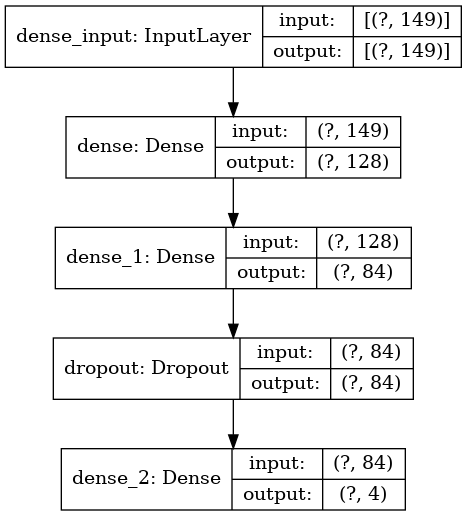

In [100]:
%%time

#***CREATE model_dir in local VM***
!mkdir -p model_dir

from trainer import model

# Copy the model from storage to local memory
!gsutil -m cp -r $best_model_dir_pyth* ./model_dir

# Load the model
loaded_model = tf.keras.models.load_model('./model_dir', compile=False)#, 
               #custom_objects={"custom_loss": model.custom_loss, "custom_mse": model.custom_mse})
print("Signature ", loaded_model.signatures)
print("")

# Display model
tf.keras.utils.plot_model(loaded_model, show_shapes=True)


------
# Training

In [101]:
# Create the config directory and load the trainer files in it
!mkdir -p config


In [102]:
%%writefile ./config/config.yaml

# python3
# ==============================================================================
# Copyright 2020 Google LLC. This software is provided as-is, without warranty
# or representation for any use or purpose. Your use of it is subject to your
# agreement with Google.
# ==============================================================================

# https://cloud.google.com/sdk/gcloud/reference/ai-platform/jobs/submit/training#--scale-tier
# https://www.kaggle.com/c/passenger-screening-algorithm-challenge/discussion/37087
# https://cloud.google.com/ai-platform/training/docs/using-gpus

#trainingInput:
#    scaleTier: CUSTOM
#    masterType: n1-highmem-16
#    masterConfig:
#        acceleratorConfig:
#            count: 2
#            type: NVIDIA_TESLA_V100

#trainingInput:
#  scaleTier: CUSTOM
#  masterType: n1-highmem-8
#  masterConfig:
#    acceleratorConfig:
#      count: 1
#      type: NVIDIA_TESLA_T4

#  masterType: n1-highcpu-16
#  workerType: cloud_tpu
#  workerCount: 1
#  workerConfig:
#    acceleratorConfig:
#      type: TPU_V3
#      count: 8

#trainingInput:
#  scaleTier: CUSTOM
#  masterType: complex_model_m
#  workerType: complex_model_m
#  parameterServerType: large_model
#  workerCount: 6
#  parameterServerCount: 1
#  scheduling:
#    maxWaitTime: 3600s
#    maxRunningTime: 7200s

#trainingInput:
#  runtimeVersion: "2.1"
#  scaleTier: CUSTOM
#  masterType: standard_gpu
#  workerCount: 9
#  workerType: standard_gpu
#  parameterServerCount: 3
#  parameterServerType: standard

#trainingInput:
#  scaleTier: BASIC-GPU
    
#trainingInput:
#  region: us-central1
#  scaleTier: CUSTOM
#  masterType: complex_model_m
#  workerType: complex_model_m_gpu
#  parameterServerType: large_model
#  workerCount: 4
#  parameterServerCount: 2

trainingInput:
  scaleTier: standard-1


Overwriting ./config/config.yaml


In [103]:
from datetime import datetime
from pytz import timezone
JOBNAME_TRN = 'tf_train_'+ USER + '_' + \
           datetime.now(timezone('US/Pacific')).strftime("%m%d%y_%H%M")
JOB_CONFIG = "config/config.yaml"
MODEL_DIR_TRN = MODEL_DIR + datetime.now(timezone('US/Pacific')).strftime('/model_%m%d%Y_%H%M')
INPUT_FILE = 'gs://' + BUCKET_NAME + '/' + FOLDER_DATA + '/' + INPUT_FILE_NAME

print("Job Name = ", JOBNAME_TRN)
print("Job Dir  = ", JOB_DIR)
print("MODEL_DIR =", MODEL_DIR_TRN)
print("INPUT_FILE =", INPUT_FILE)

# Training parameters
MODEL_DEPTH = 3
DROPOUT_RATE = 0.02
LEARNING_RATE = 0.0001
EPOCHS = 2
BATCH_SIZE = 32

print('MODEL_DEPTH = %2d' % MODEL_DEPTH)
print('DROPOUT_RATE = %.4f' % DROPOUT_RATE)
print('LEARNING_RATE = %.6f' % LEARNING_RATE)
print('EPOCHS = %2d' % EPOCHS)
print('BATCH_SIZE = %2d' % BATCH_SIZE)



Job Name =  tf_train_cchatterj_050721_2029
Job Dir  =  gs://tuti_asset/tf_models/jobdir
MODEL_DIR = gs://tuti_asset/tf_models/models/model_05072021_2029
INPUT_FILE = gs://tuti_asset/datasets/mortgage_structured.csv
MODEL_DEPTH =  3
DROPOUT_RATE = 0.0200
LEARNING_RATE = 0.000100
EPOCHS =  2
BATCH_SIZE = 32


In [104]:
# https://cloud.google.com/sdk/gcloud/reference/ai-platform/jobs/submit/training

TRAIN_LABELS = "mode=train,owner="+USER

# submit the training job
! gcloud ai-platform jobs submit training $JOBNAME_TRN \
  --package-path $(pwd)/trainer \
  --module-name trainer.train \
  --region $REGION \
  --python-version 3.7 \
  --runtime-version $RUNTIME_VERSION \
  --job-dir $JOB_DIR \
  --config $JOB_CONFIG \
  --labels $TRAIN_LABELS \
  -- \
  --model_depth=$MODEL_DEPTH \
  --dropout_rate=$DROPOUT_RATE \
  --learning_rate=$LEARNING_RATE \
  --epochs=$EPOCHS \
  --batch_size=$BATCH_SIZE \
  --model_dir=$MODEL_DIR_TRN \
  --input_file=$INPUT_FILE


Job [tf_train_cchatterj_050721_2029] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe tf_train_cchatterj_050721_2029

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs tf_train_cchatterj_050721_2029
jobId: tf_train_cchatterj_050721_2029
state: QUEUED


In [105]:
# check the training job status
! gcloud ai-platform jobs describe $JOBNAME_TRN


createTime: '2021-05-08T03:29:28Z'
endTime: '2021-05-08T03:38:43Z'
etag: F-hA7AzGb84=
jobId: tf_train_cchatterj_050721_2029
labels:
  mode: train
  owner: cchatterj
startTime: '2021-05-08T03:37:12Z'
state: SUCCEEDED
trainingInput:
  args:
  - --model_depth=3
  - --dropout_rate=0.02
  - --learning_rate=0.0001
  - --epochs=2
  - --batch_size=32
  - --model_dir=gs://tuti_asset/tf_models/models/model_05072021_2029
  - --input_file=gs://tuti_asset/datasets/mortgage_structured.csv
  jobDir: gs://tuti_asset/tf_models/jobdir
  packageUris:
  - gs://tuti_asset/tf_models/jobdir/packages/4f8ba8fc866713a6e7b8f4202c38ae66bd5913b96f7539c634af9e14cc419131/trainer-0.1.tar.gz
  pythonModule: trainer.train
  pythonVersion: '3.7'
  region: us-central1
  runtimeVersion: '2.1'
  scaleTier: STANDARD_1
trainingOutput:
  consumedMLUnits: 0.68

View job in the Cloud Console at:
https://console.cloud.google.com/mlengine/jobs/tf_train_cchatterj_050721_2029?project=img-seg-3d

View logs at:
https://console.cloud.

In [106]:
# Print Errors
#response = ! gcloud logging read "resource.labels.job_id=$JOBNAME_TRN severity>=ERROR"
#for i in range(0,len(response)):
#    if 'message' in response[i]:
#        print(response[i])

In [107]:
# Test with latest saved model
best_model_dir_trn = find_best_model_dir(MODEL_DIR_TRN+'/checkpoints', offset=1, maxFlag=1)
#acc = test_saved_model(best_model_dir_trn, 0)



All Models = 
gs://tuti_asset/tf_models/models/model_05072021_2029/checkpoints/
gs://tuti_asset/tf_models/models/model_05072021_2029/checkpoints/cp-203733-0-0.9289/
gs://tuti_asset/tf_models/models/model_05072021_2029/checkpoints/cp-203742-0-0.0186/
gs://tuti_asset/tf_models/models/model_05072021_2029/checkpoints/cp-203742-0-0.9289/
gs://tuti_asset/tf_models/models/model_05072021_2029/checkpoints/cp-203745-0-0.9289/
gs://tuti_asset/tf_models/models/model_05072021_2029/checkpoints/cp-203747-0-0.9289/
gs://tuti_asset/tf_models/models/model_05072021_2029/checkpoints/cp-203750-0-0.0340/
gs://tuti_asset/tf_models/models/model_05072021_2029/checkpoints/cp-203750-0-0.9289/
gs://tuti_asset/tf_models/models/model_05072021_2029/checkpoints/cp-203835-0-0.9289/
gs://tuti_asset/tf_models/models/model_05072021_2029/checkpoints/cp-203742-0-0.0186/
gs://tuti_asset/tf_models/models/model_05072021_2029/checkpoints/cp-203750-0-0.0340/
gs://tuti_asset/tf_models/models/model_05072021_2029/checkpoints/cp-2

------
# Hyper Parameter Tuning

In [108]:
# Create the tf directory and load the trainer files in it
!cp ./trainer/train.py ./trainer/train_hpt.py


In [109]:
%%writefile -a ./trainer/train_hpt.py

    """This method updates a CAIP HPTuning Job with a final metric for the job.
    In TF2.X the user must either use hypertune or a custom callback with
    tf.summary.scalar to update CAIP HP Tuning jobs. This function uses
    hypertune, which appears to be the preferred solution. Hypertune also works
    with containers, without code change.
    Args:
        metric_tag: The metric being optimized.  This MUST MATCH the
          hyperparameterMetricTag specificed in the hyperparameter tuning yaml.
        metric_value: The value to report at the end of model training.
        global_step: An int value to specify the number of trainin steps completed
          at the time the metric was reported.
    """

    hpt = hypertune.HyperTune()
    hpt.report_hyperparameter_tuning_metric(
        hyperparameter_metric_tag='accuracy',
        metric_value=final_epoch_accuracy,
        global_step=final_epoch_count
    )


Appending to ./trainer/train_hpt.py


In [113]:
%%writefile ./config/hptuning_config.yaml

# python3
# ==============================================================================
# Copyright 2020 Google LLC. This software is provided as-is, without warranty
# or representation for any use or purpose. Your use of it is subject to your
# agreement with Google.
# ==============================================================================

# https://cloud.google.com/ai-platform/training/docs/reference/rest/v1/projects.jobs
# https://cloud.google.com/sdk/gcloud/reference/ai-platform/jobs/submit/training

#trainingInput:
#  scaleTier: CUSTOM
#  masterType: n1-highmem-8
#  masterConfig:
#    acceleratorConfig:
#      count: 1
#      type: NVIDIA_TESLA_T4
#
#  masterType: standard_p100
#  workerType: standard_p100
#  parameterServerType: standard_p100
#  workerCount: 8
#  parameterServerCount: 1
#  runtimeVersion: $RUNTIME_VERSION
#  pythonVersion: '3.7'

#trainingInput:
#  scaleTier: CUSTOM
#  masterType: complex_model_m
#  workerType: complex_model_m
#  parameterServerType: large_model
#  workerCount: 9
#  parameterServerCount: 3
#  scheduling:
#    maxWaitTime: 3600s
#    maxRunningTime: 7200s

#trainingInput:
#  scaleTier: BASIC-GPU

#trainingInput:
#  scaleTier: CUSTOM
#  masterType: n1-highmem-16
#  masterConfig:
#    acceleratorConfig:
#      count: 2
#      type: NVIDIA_TESLA_V100

trainingInput:
  scaleTier: STANDARD-1
  hyperparameters:
    goal: MAXIMIZE
    hyperparameterMetricTag: accuracy
    maxTrials: 4
    maxParallelTrials: 4
    enableTrialEarlyStopping: True
    params:
    - parameterName: model_depth
      type: INTEGER
      minValue: 2
      maxValue: 4
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: epochs
      type: INTEGER
      minValue: 1
      maxValue: 3
      scaleType: UNIT_LINEAR_SCALE


Overwriting ./config/hptuning_config.yaml


In [116]:
from datetime import datetime
from pytz import timezone

JOBNAME_HPT = 'tf_hptrn_' + USER + '_' + \
              datetime.now(timezone('US/Pacific')).strftime("%m%d%y_%H%M")
JOB_CONFIG = "./config/hptuning_config.yaml"
MODEL_DIR_HPT = MODEL_DIR + datetime.now(timezone('US/Pacific')).strftime('/model_%m%d%Y_%H%M')
INPUT_FILE = 'gs://' + BUCKET_NAME + '/' + FOLDER_DATA + '/' + INPUT_FILE_NAME

print("Job Name = ", JOBNAME_HPT)
print("Job Dir  = ", JOB_DIR)
print("MODEL_DIR =", MODEL_DIR_HPT)
print("INPUT_FILE =", INPUT_FILE)

# Training parameters
DROPOUT_RATE = 0.02
LEARNING_RATE = 0.0001
BATCH_SIZE = 32


Job Name =  tf_hptrn_cchatterj_050721_2125
Job Dir  =  gs://tuti_asset/tf_models/jobdir
MODEL_DIR = gs://tuti_asset/tf_models/models/model_05072021_2125
INPUT_FILE = gs://tuti_asset/datasets/mortgage_structured.csv


In [117]:
# submit the training job
HT_LABELS = "mode=hypertrain,owner="+USER

! gcloud ai-platform jobs submit training $JOBNAME_HPT \
  --package-path $(pwd)/trainer \
  --module-name trainer.train_hpt \
  --python-version 3.7 \
  --runtime-version $RUNTIME_VERSION \
  --region $REGION \
  --job-dir $JOB_DIR \
  --config $JOB_CONFIG \
  --labels $HT_LABELS \
  -- \
  --dropout_rate=$DROPOUT_RATE \
  --learning_rate=$LEARNING_RATE \
  --batch_size=$BATCH_SIZE \
  --model_dir=$MODEL_DIR_HPT \
  --input_file=$INPUT_FILE


Job [tf_hptrn_cchatterj_050721_2125] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe tf_hptrn_cchatterj_050721_2125

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs tf_hptrn_cchatterj_050721_2125
jobId: tf_hptrn_cchatterj_050721_2125
state: QUEUED


In [119]:
# check the hyperparameter training job status
! gcloud ai-platform jobs describe $JOBNAME_HPT


createTime: '2021-05-08T04:25:37Z'
endTime: '2021-05-08T04:38:34Z'
etag: wGblmgO1A8o=
jobId: tf_hptrn_cchatterj_050721_2125
labels:
  mode: hypertrain
  owner: cchatterj
startTime: '2021-05-08T04:25:42Z'
state: SUCCEEDED
trainingInput:
  args:
  - --dropout_rate=0.02
  - --learning_rate=0.0001
  - --batch_size=32
  - --model_dir=gs://tuti_asset/tf_models/models/model_05072021_2125
  - --input_file=gs://tuti_asset/datasets/mortgage_structured.csv
  hyperparameters:
    enableTrialEarlyStopping: true
    goal: MAXIMIZE
    hyperparameterMetricTag: accuracy
    maxParallelTrials: 4
    maxTrials: 4
    params:
    - maxValue: 4.0
      minValue: 2.0
      parameterName: model_depth
      scaleType: UNIT_LINEAR_SCALE
      type: INTEGER
    - maxValue: 3.0
      minValue: 1.0
      parameterName: epochs
      scaleType: UNIT_LINEAR_SCALE
      type: INTEGER
  jobDir: gs://tuti_asset/tf_models/jobdir
  packageUris:
  - gs://tuti_asset/tf_models/jobdir/packages/481b3b998d8665967bd09bd0076485

In [120]:
# Print Errors
#response = ! gcloud logging read "resource.labels.job_id=$JOBNAME_HPT severity>=ERROR"
#for i in range(0,len(response)):
#    if 'message' in response[i]:
#        print(response[i])

In [121]:
# Get the best model parameters from Cloud API
best_model = pyth_get_hypertuned_parameters(PROJECT_ID, JOBNAME_HPT, 1)
MODEL_DEPTH = best_model['hyperparameters']['model_depth']
EPOCHS = best_model['hyperparameters']['epochs']
print('')
print('Objective=', best_model['finalMetric']['objectiveValue'])
print('MODEL_DEPTH =', MODEL_DEPTH)
print('EPOCHS =', EPOCHS)


objective= 0.9335856437683105  trialId= 3 SUCCEEDED
     epochs 3
     model_depth 4
objective= 0.9270378947257996  trialId= 2 SUCCEEDED
     epochs 2
     model_depth 3
objective= 0.9170901775360107  trialId= 4 SUCCEEDED
     epochs 1
     model_depth 4
objective= 0.12712199985980988  trialId= 1 SUCCEEDED
     epochs 3
     model_depth 3

Objective= 0.9335856437683105
MODEL_DEPTH = 4
EPOCHS = 3


In [122]:
# Find count of checkpoints
all_models = ! gsutil ls {MODEL_DIR_HPT+'/checkpoints'}
print("Total Hypertrained Models=", len(all_models))

# Test with latest saved model
best_model_dir_hyp = find_best_model_dir(MODEL_DIR_HPT+'/checkpoints', offset=1, maxFlag=1)
#acc = test_saved_model(best_model_dir_hyp, 0)

#import keras.backend as K
#loaded_model = tf.keras.models.load_model(MODEL_DIR_PARAM+'/checkpoints')
#print("learning_rate=", K.eval(loaded_model.optimizer.lr))
#tf.keras.utils.plot_model(loaded_model, show_shapes=True)


Total Hypertrained Models= 36

All Models = 
gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/
gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213445-3-0.9289/
gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213503-2-0.9289/
gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213503-3-0.0185/
gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213503-3-0.0340/
gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213506-3-0.9289/
gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213507-2-0.0185/
gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213508-4-0.0186/
gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213510-4-0.9289/
gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213513-2-0.9289/
gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213513-3-0.9289/
gs://tuti_asset/tf_models/models/model_

--------
# Deploy the Model

In [123]:
## https://cloud.google.com/ai-platform/prediction/docs/machine-types-online-prediction#available_machine_types
# We need 2 versions of the same model:
# 1. Batch prediction model deployed on a mls1-c1-m2 cluster
# 2. Online prediction model deployed on a n1-standard-16 cluster
# Batch prediction does not support GPU and n1-standard-16 clusters.

# Run the Deploy Model section twice:
# 1. As a BATCH Mode version use MODEL_VERSION = MODEL_VERSION_BATCH
# 2. As a ONLINE Mode version use MODEL_VERSION = MODEL_VERSION_ONLINE


In [124]:
# Regional End points with python
#https://cloud.google.com/ai-platform/prediction/docs/regional-endpoints#python

In [135]:
MODEL_NAME = "loan_model_1"
MODEL_VERSION_BATCH  = "batch_v1"
MODEL_VERSION_ONLINE = "online_v1"

#Run this as Batch first then Online
#MODEL_VERSION = MODEL_VERSION_ONLINE
MODEL_VERSION = MODEL_VERSION_BATCH

# List all models

print("\nList of Models in Global Endpoint)")
!gcloud ai-platform models list --region=global

# List all versions of model

print("\nList of Versions in Global Endpoint)")
!gcloud ai-platform versions list --model $MODEL_NAME --region=global



List of Models in Global Endpoint)
Using endpoint [https://ml.googleapis.com/]
NAME           DEFAULT_VERSION_NAME
kfp_xgb_model  kfp_xgb_bst_v0_1
loan_model_1   online_v1
mnist_model_1  online_v1
xgb_model      elvinzhu_xgb_bst

List of Versions in Global Endpoint)
Using endpoint [https://ml.googleapis.com/]
NAME       DEPLOYMENT_URI                                                                        STATE
online_v1  gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213513-3-0.9496/  READY


In [136]:
#!gcloud ai-platform versions delete $MODEL_VERSION_BATCH --model $MODEL_NAME --quiet --region=global
#!gcloud ai-platform models delete $MODEL_NAME --quiet --region=global


In [137]:
# List all models

print("\nList of Models in Global Endpoint)")
!gcloud ai-platform models list --region=global

# List all versions of model

print("\nList of Versions in Global Endpoint)")
!gcloud ai-platform versions list --model $MODEL_NAME --region=global



List of Models in Global Endpoint)
Using endpoint [https://ml.googleapis.com/]
NAME           DEFAULT_VERSION_NAME
kfp_xgb_model  kfp_xgb_bst_v0_1
loan_model_1   online_v1
mnist_model_1  online_v1
xgb_model      elvinzhu_xgb_bst

List of Versions in Global Endpoint)
Using endpoint [https://ml.googleapis.com/]
NAME       DEPLOYMENT_URI                                                                        STATE
online_v1  gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213513-3-0.9496/  READY


In [138]:
# create the model if it doesn't already exist
modelname = !gcloud ai-platform models list | grep -w $MODEL_NAME
print(modelname)
if (len(modelname) <= 1) or ('Listed 0 items.' in modelname[1]):
    print("Creating model " + MODEL_NAME)
    # Global endpoint
    !gcloud ai-platform models create $MODEL_NAME --enable-logging --regions $REGION
else:
    print("Model " + MODEL_NAME + " exist")
    
print("\nList of Models in Global Endpoint)")
!gcloud ai-platform models list --region=global


['Using endpoint [https://us-central1-ml.googleapis.com/]', 'Listed 0 items.']
Creating model loan_model_1
Using endpoint [https://ml.googleapis.com/]
ERROR: (gcloud.ai-platform.models.create) Resource in projects [img-seg-3d] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name

List of Models in Global Endpoint)
Using endpoint [https://ml.googleapis.com/]
NAME           DEFAULT_VERSION_NAME
kfp_xgb_model  kfp_xgb_bst_v0_1
loan_model_1   online_v1
mnist_model_1  online_v1
xgb_model      elvinzhu_xgb_bst


In [139]:
%%time

print("Model Name =", MODEL_NAME)
print("Model Versions =", MODEL_VERSION)

# Get a list of model directories
best_model_dir = best_model_dir_hyp
print("Best Model Dir: ", best_model_dir)

MODEL_FRAMEWORK = "TENSORFLOW"
MODEL_DESCRIPTION = "SEQ_MODEL_1"
MODEL_LABELS="team=ourteam,phase=test,owner="+USER

MACHINE_TYPE = "mls1-c1-m2"
if (MODEL_VERSION == MODEL_VERSION_BATCH):
    MACHINE_TYPE = "mls1-c1-m2"
    MODEL_LABELS = MODEL_LABELS+",mode=batch"
if (MODEL_VERSION == MODEL_VERSION_ONLINE):
    MACHINE_TYPE = "mls1-c1-m2" #"n1-standard-32"
    MODEL_LABELS = MODEL_LABELS+",mode=online"

# Deploy the model
! gcloud beta ai-platform versions create $MODEL_VERSION \
  --model $MODEL_NAME \
  --origin $best_model_dir \
  --runtime-version $RUNTIME_VERSION \
  --python-version=3.7 \
  --description=$MODEL_DESCRIPTION \
  --labels $MODEL_LABELS \
  --machine-type=$MACHINE_TYPE  \
  --framework $MODEL_FRAMEWORK \
  --region global


Model Name = loan_model_1
Model Versions = batch_v1
Best Model Dir:  gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213513-3-0.9496/
Using endpoint [https://ml.googleapis.com/]
Creating version (this might take a few minutes)......done.                    
CPU times: user 1.21 s, sys: 348 ms, total: 1.56 s
Wall time: 52.2 s


In [140]:
# List all models

print("\nList of Models in Global Endpoint)")
!gcloud ai-platform models list --region=global

print("\nList of Models in Regional Endpoint)")
!gcloud ai-platform models list --region=$REGION

# List all versions of model

print("\nList of Versions in Global Endpoint)")
!gcloud ai-platform versions list --model $MODEL_NAME --region=global

#print("\nList of Versions in Regional Endpoint)")
#!gcloud ai-platform versions list --model $MODEL_NAME --region=$REGION



List of Models in Global Endpoint)
Using endpoint [https://ml.googleapis.com/]
NAME           DEFAULT_VERSION_NAME
kfp_xgb_model  kfp_xgb_bst_v0_1
loan_model_1   online_v1
mnist_model_1  online_v1
xgb_model      elvinzhu_xgb_bst

List of Models in Regional Endpoint)
Using endpoint [https://us-central1-ml.googleapis.com/]
Listed 0 items.

List of Versions in Global Endpoint)
Using endpoint [https://ml.googleapis.com/]
NAME       DEPLOYMENT_URI                                                                        STATE
batch_v1   gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213513-3-0.9496/  READY
online_v1  gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213513-3-0.9496/  READY


------
# Predictions with the deployed model

In [141]:
%%time

from trainer import model

# Copy the model from storage to local memory
!gsutil -m cp -r $best_model_dir_hyp* ./model_dir

# Load the model
loaded_model = tf.keras.models.load_model('./model_dir', compile=False) #, 
               #custom_objects={"custom_loss": model.custom_loss,"custom_mse": model.custom_mse})
print("Signature ", loaded_model.signatures)

# Check the model layers
model_layers = [layer.name for layer in loaded_model.layers]
print("")
print("Model Input  Layer=", model_layers[0])
print("Model Output Layer=", model_layers[-1])
print("")


Copying gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213513-3-0.9496/saved_model.pb...
Copying gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213513-3-0.9496/variables/variables.data-00000-of-00001...
Copying gs://tuti_asset/tf_models/models/model_05072021_2125/checkpoints/cp-213513-3-0.9496/variables/variables.index...
Signature  _SignatureMap({'serving_default': <tensorflow.python.saved_model.load._WrapperFunction object at 0x7f8546b9bbd0>})

Model Input  Layer= dense
Model Output Layer= dense_4

CPU times: user 411 ms, sys: 52.8 ms, total: 464 ms
Wall time: 1.95 s


In [142]:
from trainer import inputs
input_file = 'gs://' + BUCKET_NAME + '/' + FOLDER_DATA + '/' + INPUT_FILE_NAME
train_test_data = inputs.load_data(input_file)
X_test  = train_test_data[1]
y_test  = train_test_data[3]


gs://tuti_asset/datasets/mortgage_structured.csv
(104044, 48)
X_train shape =  (83235, 149)
X_test  shape =  (20809, 149)
y_train shape =  (83235, 4)
y_test  shape =  (20809, 4)


## Online Prediction with python

In [143]:
%%time

# Online Prediction with Python - works for global end points only

# Use MODEL_VERSION_ONLINE not MODEL_VERSION_BATCH
MODEL_VERSION = MODEL_VERSION_ONLINE

from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors
import json

#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#tf.get_logger().setLevel('ERROR')

print("Project ID =", PROJECT_ID)
print("Model Name =", MODEL_NAME)
print("Model Version =", MODEL_VERSION)

model_name = 'projects/{}/models/{}'.format(PROJECT_ID, MODEL_NAME)
if MODEL_VERSION is not None:
    model_name += '/versions/{}'.format(MODEL_VERSION)
credentials = GoogleCredentials.get_application_default()
service = discovery.build('ml', 'v1', cache_discovery=False, credentials=credentials)
print("model_name=", model_name)

pprobas_temp = []
batch_size = 32
n_samples = min(1000,X_test.shape[0])
print("batch_size=", batch_size)
print("n_samples=", n_samples)

for i in range(0, n_samples, batch_size):
    j = min(i+batch_size, n_samples)
    print("Processing samples", i, j)
    request = service.projects().predict(name=model_name, \
                                         body={'instances': np.array(X_test)[i:j].tolist()})
    try:
        response = request.execute()
        pprobas_temp += response['predictions']
    except errors.HttpError as err:
        # Something went wrong, print out some information.
        tf.compat.v1.logging.error('There was an error getting the job info, Check the details:')
        tf.compat.v1.logging.error(err._get_reason())
        break


Project ID = img-seg-3d
Model Name = loan_model_1
Model Version = online_v1
model_name= projects/img-seg-3d/models/loan_model_1/versions/online_v1
batch_size= 32
n_samples= 1000
Processing samples 0 32
Processing samples 32 64
Processing samples 64 96
Processing samples 96 128
Processing samples 128 160
Processing samples 160 192
Processing samples 192 224
Processing samples 224 256
Processing samples 256 288
Processing samples 288 320
Processing samples 320 352
Processing samples 352 384
Processing samples 384 416
Processing samples 416 448
Processing samples 448 480
Processing samples 480 512
Processing samples 512 544
Processing samples 544 576
Processing samples 576 608
Processing samples 608 640
Processing samples 640 672
Processing samples 672 704
Processing samples 704 736
Processing samples 736 768
Processing samples 768 800
Processing samples 800 832
Processing samples 832 864
Processing samples 864 896
Processing samples 896 928
Processing samples 928 960
Processing samples 9

In [144]:
# Show the prediction results as an array

nPreds = len(pprobas_temp)
nClasses = y_test.shape[1]
pprobas = np.zeros((nPreds, nClasses))
for i in range(nPreds):
    pprobas[i,:] = np.array(pprobas_temp[i][model_layers[-1]])
pprobas = np.round(pprobas, 2)
pprobas


array([[0.24, 0.02, 0.18, 0.56],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       ...,
       [1.  , 0.  , 0.  , 0.  ],
       [0.95, 0.01, 0.02, 0.01],
       [0.24, 0.04, 0.21, 0.51]])

## Batch Prediction with GCLOUD

In [145]:
# Write batch data to file in GCS

import shutil

# Clean current directory
DATA_DIR = './batch_data'
shutil.rmtree(DATA_DIR, ignore_errors=True)
os.makedirs(DATA_DIR)

n_samples = min(1000,X_test.shape[0])
nFiles = 10
nRecsPerFile = min(1000,n_samples//nFiles)
print("n_samples =", n_samples)
print("nFiles =", nFiles)
print("nRecsPerFile =", nRecsPerFile)

# Create nFiles files with nImagesPerFile images each
for i in range(nFiles):
    with open(f'{DATA_DIR}/unkeyed_batch_{i}.json', "w") as file:
        for z in range(nRecsPerFile):
            print(f'{{"dense_input": {np.array(X_test)[i*nRecsPerFile+z].tolist()}}}', file=file)
            #print(f'{{"{model_layers[0]}": {np.array(X_test)[i*nRecsPerFile+z].tolist()}}}', file=file)
            #key = f'key_{i}_{z}'
            #print(f'{{"image": {X_test_images[z].tolist()}, "key": "{key}"}}', file=file)

# Write batch data to gcs file
!gsutil -m cp -r ./batch_data gs://$BUCKET_NAME/$FOLDER_RESULTS/
    
# Remove old batch prediction results
!gsutil -m rm -r gs://$BUCKET_NAME/$FOLDER_RESULTS/batch_predictions


n_samples = 1000
nFiles = 10
nRecsPerFile = 100
Copying file://./batch_data/unkeyed_batch_2.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_5.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_3.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_6.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_9.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_1.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_8.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_7.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_0.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_4.json [Content-Type=application/json]...
/ [10/10 files][870.8 KiB/870.8 KiB] 100% Done                                  
Operation completed over 10 obj

In [146]:
from datetime import datetime
from pytz import timezone

DATA_FORMAT="text" # JSON data format
INPUT_PATHS='gs://' + BUCKET_NAME + '/' + FOLDER_RESULTS + '/batch_data/*'
OUTPUT_PATH='gs://' + BUCKET_NAME + '/' + FOLDER_RESULTS + '/batch_predictions'
PRED_LABELS="mode=batch,team=ourteam,phase=test,owner="+USER
SIGNATURE_NAME="serving_default"

JOBNAME_BATCH = 'tf_batch_predict_'+ USER + '_' + \
           datetime.now(timezone('US/Pacific')).strftime("%m%d%y_%H%M")

print("INPUT_PATHS = ", INPUT_PATHS)
print("OUTPUT_PATH = ", OUTPUT_PATH)
print("Job Name    = ", JOBNAME_BATCH)


INPUT_PATHS =  gs://tuti_asset/tf_models/batch_data/*
OUTPUT_PATH =  gs://tuti_asset/tf_models/batch_predictions
Job Name    =  tf_batch_predict_cchatterj_050721_2217


In [147]:
# Only works with global endpoint
# Submit batch predict job
# Use  MODEL_VERSION_BATCH not MODEL_VERSION_ONLINE
MODEL_VERSION = MODEL_VERSION_BATCH

!gcloud ai-platform jobs submit prediction $JOBNAME_BATCH \
    --model=$MODEL_NAME \
    --version=$MODEL_VERSION \
    --input-paths=$INPUT_PATHS \
    --output-path=$OUTPUT_PATH \
    --data-format=$DATA_FORMAT \
    --labels=$PRED_LABELS \
    --signature-name=$SIGNATURE_NAME \
    --region=$REGION


Job [tf_batch_predict_cchatterj_050721_2217] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe tf_batch_predict_cchatterj_050721_2217

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs tf_batch_predict_cchatterj_050721_2217
jobId: tf_batch_predict_cchatterj_050721_2217
state: QUEUED


In [148]:
# check the batch prediction job status
! gcloud ai-platform jobs describe $JOBNAME_BATCH


createTime: '2021-05-08T05:17:55Z'
endTime: '2021-05-08T05:24:48Z'
etag: VtPn6bp-80g=
jobId: tf_batch_predict_cchatterj_050721_2217
labels:
  mode: batch
  owner: cchatterj
  phase: test
  team: ourteam
predictionInput:
  dataFormat: JSON
  inputPaths:
  - gs://tuti_asset/tf_models/batch_data/*
  outputPath: gs://tuti_asset/tf_models/batch_predictions
  region: us-central1
  runtimeVersion: '2.1'
  signatureName: serving_default
  versionName: projects/img-seg-3d/models/loan_model_1/versions/batch_v1
predictionOutput:
  nodeHours: 0.13
  outputPath: gs://tuti_asset/tf_models/batch_predictions
  predictionCount: '1000'
startTime: '2021-05-08T05:17:56Z'
state: SUCCEEDED

View job in the Cloud Console at:
https://console.cloud.google.com/mlengine/jobs/tf_batch_predict_cchatterj_050721_2217?project=img-seg-3d

View logs at:
https://console.cloud.google.com/logs?resource=ml_job%2Fjob_id%2Ftf_batch_predict_cchatterj_050721_2217&project=img-seg-3d


In [149]:
# Print Errors
#response = ! gcloud logging read "resource.labels.job_id=$JOBNAME_BATCH severity>=ERROR"
#for i in range(0,len(response)):
#    if 'message' in response[i]:
#        print(response[i])


In [150]:
print("errors")
!gsutil cat $OUTPUT_PATH/prediction.errors_stats-00000-of-00001
print("batch prediction results")
!gsutil cat $OUTPUT_PATH/prediction.results-00000-of-00010


errors
batch prediction results
{"dense_4": [1.0, 1.0406388993958553e-19, 1.4212099800694908e-16, 8.73646490846459e-18]}
{"dense_4": [0.9950793981552124, 0.0003781084669753909, 0.002196859335526824, 0.0023456888739019632]}
{"dense_4": [0.9471668601036072, 0.013947566971182823, 0.02370576374232769, 0.015179785899817944]}
{"dense_4": [0.9389595985412598, 0.014931815676391125, 0.02704501897096634, 0.01906345598399639]}
{"dense_4": [0.9999895095825195, 3.8273580571512866e-07, 6.259979272726923e-06, 3.77660262529389e-06]}
{"dense_4": [0.9965618252754211, 0.0006547770462930202, 0.0018533668480813503, 0.0009299058583565056]}
{"dense_4": [0.9855900406837463, 0.00351746310479939, 0.007098924834281206, 0.003793543903157115]}
{"dense_4": [0.9927776455879211, 0.0010063608642667532, 0.0035145131405442953, 0.0027014994993805885]}
{"dense_4": [0.8834134340286255, 0.012198326177895069, 0.042322881519794464, 0.062065403908491135]}
{"dense_4": [0.9787063002586365, 0.002845538081601262, 0.009469740092754